In [3]:
# !pip install pyproj
# !pip install geopandas
# !pip install vincent

In [4]:
import pathlib
import random
from functools import reduce
from collections import defaultdict
import warnings
warnings.filterwarnings(action='ignore')
from functools import partial
from shapely import ops
import pyproj
import json, math
import matplotlib.pyplot as plt
from folium import plugins
import re
from matplotlib import font_manager, rc, rcParams
from shapely.geometry import Point as shapely_Point
from geopy.distance import great_circle as distance
from geopy.point import Point as Point
from math import sin, cos, atan2, sqrt, degrees, radians, pi
from IPython.display import display
import branca
from branca.colormap import linear
from geopy.distance import geodesic
import folium
from folium import plugins
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import os
import datetime
def reproject(geom, from_proj=None, to_proj=None):
    tfm = partial(pyproj.transform, pyproj.Proj(init=from_proj), pyproj.Proj(init=to_proj))
    return ops.transform(tfm, geom)
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import time
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score,accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score, f1_score, recall_score, precision_score
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from itertools import combinations
center = (37.1623799231016, 127.05436890115905)
plt.style.use(['ggplot'])
rs = 123
np.random.seed(rs)
random.seed(rs)

In [5]:
df1 = pd.read_csv('C:/Users/simjh96/OneDrive/문서/Car_Accident/model/data/feature25.csv')

In [6]:
learn_cols = ["lon",
              "lat",
              "overspeed_cam_count100",
              "floating_pop_count50",
              "shortest_bump_dist",
              "parking_count12.5",
              "parking_count25",
              "car_count1000", 
              "child_count1000",
              "elem_kinder_count400",
              "numberSchoolZone_count400",
              "num_cram_school_count400",
              "shortest_cross_dist",
              "shortest_traffic_signal_dist",
              "shortest_sidewalk_dist",
              "barrier_nearby_count12.5",
              "barrier_nearby_count25",
              "chaos1_nearby_count12.5",
              "chaos1_nearby_count25",
              "width_nearby_count12.5",
              "width_nearby_count25",
              "cross_road_nearby_count12.5",
              "cross_road_nearby_count25"]

clust_cols = ["floating_pop_count50",
        "parking_count25",
        "car_count1000", 
        "child_count1000",
        "elem_kinder_count400",
        "numberSchoolZone_count400",
        "chaos1_nearby_count25",
        "cross_road_nearby_count25",
        "num_cram_school_count400",
        "shortest_cross_dist"]

In [7]:
#df1 feature 조절
#groupby로 count 하고
#등간이라고 생각되는 만큼 조절
df1.elem_kinder_count400.loc[df1.elem_kinder_count400 == 0] = 0
df1.elem_kinder_count400.loc[(df1.elem_kinder_count400 > 0)&(df1.elem_kinder_count400 <= 10)] = 1
df1.elem_kinder_count400.loc[(df1.elem_kinder_count400 > 10)] = 2

df1.numberSchoolZone_count400.loc[(df1.numberSchoolZone_count400 ==0 )] = 0
df1.numberSchoolZone_count400.loc[(df1.numberSchoolZone_count400 > 0)&(df1.numberSchoolZone_count400 <= 2)] = 1
df1.numberSchoolZone_count400.loc[(df1.numberSchoolZone_count400 > 2)] = 2

df1.num_cram_school_count400.loc[(df1.num_cram_school_count400 ==0 )] = 0
df1.num_cram_school_count400.loc[(df1.num_cram_school_count400 > 0)&(df1.num_cram_school_count400 <= 31)] = 1
df1.num_cram_school_count400.loc[(df1.num_cram_school_count400 > 31)] = 2

df1["accident_count12.5"] = (df1["accident_count12.5"] > 0).astype(float)

df1['is_bump20'] = df1['shortest_bump_dist'] < 20
df1['is_sidewalk12.5'] = df1['shortest_sidewalk_dist'] < 12.5

In [8]:
df1.loc[:,:] = MinMaxScaler().fit_transform(df1)

x25 = df1.loc[:,learn_cols]
y25 = df1["accident_count12.5"]

x25_train, x25_test, y25_train, y25_test = train_test_split(x25, y25, test_size=0.33, random_state=3)

df2 = df1.loc[:,clust_cols]

In [9]:
#cluster 중앙값 구하는 
def centre(cluster_id):
  currentMinimum = 99999
  datas = df2.loc[labels_s == cluster_id,:].to_numpy()
  
  for point_idx in range(len(datas)):
      distance_sum = 0
      for second_point_idx in range(len(datas)):
          if point_idx == second_point_idx : continue
          distance_sum += np.linalg.norm(datas[point_idx] - datas[second_point_idx])
      # print('>>>>>', point_idx, distance_sum) 

      if distance_sum < currentMinimum :
          currentMinimum = distance_sum 
          centre_point = datas[point_idx]
  return centre_point

#클러스터 끼리 중앙값중 가장 짧은 클러스터 구하기
def closest(cluster_id, ban_list):
  currentMinimum = 99999
  clusters = list(set(labels_s))
  centre_point = centre(cluster_id)

  distance = 0
  for second_point_idx in range(len(clusters)):
    if cluster_id == clusters[second_point_idx] or (clusters[second_point_idx] in ban_list): continue
    distance = np.linalg.norm(centre_point - centre(clusters[second_point_idx]))
    # print('>>>>>', second_point_idx, distance) 

    if distance < currentMinimum :
      currentMinimum = distance 
      closest_clust = clusters[second_point_idx]

  return closest_clust

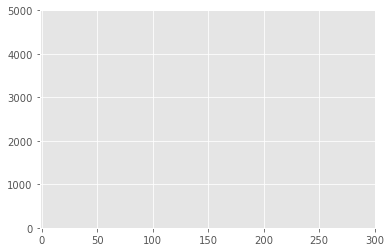

In [10]:
#hyper param search
indexs = []
for min_s in range(2,20,4):
  for eps in np.linspace(0.01,1,20):
    indexs.append([eps, min_s])

animate = []
scores = []
n_clusters = []
n_noise = []
for min_s in range(2,20,4):
  for eps in np.linspace(0.01,1,20):
    db = DBSCAN(eps=eps, min_samples=min_s).fit(df2)
    labels = db.labels_

    df3 = pd.concat([df2,pd.DataFrame(db.labels_)],axis=1)
    animate.append(df3.groupby(0).count().floating_pop_count50)
    try:
      scores.append(metrics.silhouette_score(df2, db.labels_))
    except:
      scores.append(-1)
    n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
    n_noise.append(list(labels).count(-1))

def init():
    line.set_data([], [])
    return (line,)

def animate_f(i):
    x = animate[i].index
    y = animate[i]
    line.set_data(x, y)
    ax.set_title('eps, min_samples = {}\n Silhouette Coefficient: {}'.format(indexs[i],scores[i]))
    return (line,)

fig, ax = plt.subplots()

ax.set_xlim(( -2, 300))
ax.set_ylim((0, 5000))

line, = ax.plot([], [], lw=2)

# anim = animation.FuncAnimation(fig, animate_f, init_func=init,
#                                frames=len(indexs), interval=len(indexs), blit=True)

# HTML(anim.to_html5_video())


In [11]:
#동질성이 보장될 클러스터 갯수 중 실루엣 가장 큰값
p = pd.concat([pd.DataFrame(scores),pd.DataFrame(n_clusters),pd.DataFrame(n_noise),pd.DataFrame(indexs)],axis=1)
p.columns = ['scores','n_clusters','n_noise','eps','min_sample']
p = p.sort_values(['scores']).iloc[-60:,:]

In [15]:
cv_record = []
for eps, min_s in zip(p.eps, p.min_sample):
  db = DBSCAN(eps=eps, min_samples=min_s).fit(df2)
  labels_s = db.labels_

  x25_train_l = pd.concat([df2,pd.DataFrame(labels_s)],axis=1).loc[x25_train.index,:].sort_index()
  x25_test_l = pd.concat([df2,pd.DataFrame(labels_s)],axis=1).loc[x25_test.index,:].sort_index()

  test_predict_set2 = []
  test_predict_set3 = []
  test_predict_set4 = []
  test_predict_set5 = []
  test_predict_set6 = []


  x25_test0_indexs = []

  ban_list = list(set(x25_test_l.loc[:,0]) - set(x25_train_l.loc[:,0]))

  for i in list(set(labels_s)):
    # 2nd clust == 0 인거 해보자
    if i in ban_list:
      closest_clust = closest(i,ban_list)
      print(i,"->",closest_clust)
      i = closest_clust

    x25_train0 = x25_train[x25_train_l.loc[:,0] == i]
    y25_train0 = y25_train[x25_train_l.loc[:,0] == i]
    x25_test0 = x25_test[x25_test_l.loc[:,0] == i]
    y25_test0 = y25_test[x25_test_l.loc[:,0] == i]

    if sum(x25_test_l.loc[:,0] == i) == 0: continue
    x25_test0_indexs.append(x25_test_l.loc[x25_test_l.loc[:,0] == i].index)

    model = sm.Logit(y25_train0,sm.add_constant(x25_train0,has_constant = "add"))  
    results = model.fit(method= 'lbfgs',maxiter =1000)
    predictions = results.predict(sm.add_constant(x25_test0,has_constant = "add"))
    # print(rf.predict(X_test0))
    print(i,'번째 F1 score',f1_score(y25_test0.astype(int),(predictions > 0.5).astype(int)))
    print(" ")

    test_predict_set2.append([y25_test0,(predictions > 0.2).astype(int)])
    test_predict_set3.append([y25_test0,(predictions > 0.3).astype(int)])
    test_predict_set4.append([y25_test0,(predictions > 0.4).astype(int)])
    test_predict_set5.append([y25_test0,(predictions > 0.5).astype(int)])
    test_predict_set6.append([y25_test0,(predictions > 0.6).astype(int)])
  y2 = pd.DataFrame(test_predict_set2[0][0])
  pr2 = pd.DataFrame(test_predict_set2[0][1])
  y3 = pd.DataFrame(test_predict_set3[0][0])
  pr3 = pd.DataFrame(test_predict_set3[0][1])
  y4 = pd.DataFrame(test_predict_set4[0][0])
  pr4 = pd.DataFrame(test_predict_set4[0][1])
  y5 = pd.DataFrame(test_predict_set5[0][0])
  pr5 = pd.DataFrame(test_predict_set5[0][1])
  y6 = pd.DataFrame(test_predict_set6[0][0])
  pr6 = pd.DataFrame(test_predict_set6[0][1])
    
  for i in range(len(test_predict_set2)):
    if i == 0:continue
    y2 = pd.concat((y2,pd.DataFrame(test_predict_set2[i][0])))
    pr2 = pd.concat((pr2,pd.DataFrame(test_predict_set2[i][1])))
    y3 = pd.concat((y3,pd.DataFrame(test_predict_set3[i][0])))
    pr3 = pd.concat((pr3,pd.DataFrame(test_predict_set3[i][1])))
    y4 = pd.concat((y4,pd.DataFrame(test_predict_set4[i][0])))
    pr4 = pd.concat((pr4,pd.DataFrame(test_predict_set4[i][1])))
    y5 = pd.concat((y5,pd.DataFrame(test_predict_set5[i][0])))
    pr5 = pd.concat((pr5,pd.DataFrame(test_predict_set5[i][1])))            
    y6 = pd.concat((y6,pd.DataFrame(test_predict_set6[i][0])))
    pr6 = pd.concat((pr6,pd.DataFrame(test_predict_set6[i][1])))

  f1_2 = f1_score(y2.to_numpy().reshape(len(y2)),pr2.to_numpy().reshape(len(pr2)))
  f1_3 = f1_score(y3.to_numpy().reshape(len(y3)),pr3.to_numpy().reshape(len(pr3)))
  f1_4 = f1_score(y4.to_numpy().reshape(len(y4)),pr4.to_numpy().reshape(len(pr4)))
  f1_5 = f1_score(y5.to_numpy().reshape(len(y5)),pr5.to_numpy().reshape(len(pr5)))
  f1_6 = f1_score(y6.to_numpy().reshape(len(y6)),pr6.to_numpy().reshape(len(pr6)))        
  
  cv_record.append([eps, min_s, f1_2,f1_3,f1_4,f1_5,f1_6])


0 번째 F1 score 0.3333333333333333
 
1 번째 F1 score 0.0
 
3 번째 F1 score 0.0
 
4 번째 F1 score 0.0
 
5 번째 F1 score 0.0
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.0
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.0
 
11 번째 F1 score 0.0
 
12 번째 F1 score 0.6666666666666666
 
13 번째 F1 score 0.0
 
14 번째 F1 score 0.0
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
20 번째 F1 score 0.0
 
21 번째 F1 score 0.0
 
22 번째 F1 score 0.0
 
23 번째 F1 score 0.0
 
24 번째 F1 score 0.0
 
25 번째 F1 score 0.0
 
26 번째 F1 score 0.0
 
27 번째 F1 score 0.0
 
28 번째 F1 score 0.0
 
29 번째 F1 score 0.0
 
30 번째 F1 score 0.0
 
31 번째 F1 score 0.0
 
32 번째 F1 score 0.0
 
33 번째 F1 score 0.0
 
34 번째 F1 score 0.0
 
35 번째 F1 score 0.0
 
36 번째 F1 score 0.0
 
38 번째 F1 score 0.6666666666666666
 
39 번째 F1 score 0.0
 
40 번째 F1 score 0.0
 
41 번째 F1 score 0.0
 
42 번째 F1 score 0.0
 
43 번째 F1 score 0.0
 
44 번째 F1 score 0.0
 
45 번째 F1 score 0.0
 
46 번째 F1 score 0.0
 
47 번째 F1 score 0.0
 
48 번째 F1 score 0.0


110 번째 F1 score 0.0
 
111 번째 F1 score 0.0
 
112 번째 F1 score 0.0
 
113 번째 F1 score 0.0
 
114 번째 F1 score 0.0
 
115 번째 F1 score 0.0
 
116 번째 F1 score 0.0
 
117 번째 F1 score 0.0
 
118 번째 F1 score 0.0
 
119 번째 F1 score 0.0
 
120 번째 F1 score 0.0
 
121 번째 F1 score 0.0
 
122 번째 F1 score 0.0
 
123 번째 F1 score 0.0
 
124 번째 F1 score 0.0
 
125 번째 F1 score 0.0
 
126 번째 F1 score 0.0
 
-1 번째 F1 score 0.07407407407407407
 
0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.0
 
3 번째 F1 score 0.4
 
4 번째 F1 score 0.0
 
5 번째 F1 score 0.28571428571428575
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.0
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.0
 
11 번째 F1 score 0.0
 
12 번째 F1 score 0.0
 
13 번째 F1 score 0.0
 
14 번째 F1 score 0.22222222222222224
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
19 번째 F1 score 0.0
 
20 번째 F1 score 0.0
 
21 번째 F1 score 0.0
 
22 번째 F1 score 0.0
 
23 번째 F1 score 0.0
 
24 번째 F1 score 0.0
 
25 번째 F1 score 0.0
 
26 번째 F1 score 0.0
 


160 번째 F1 score 0.0
 
161 번째 F1 score 0.0
 
162 번째 F1 score 0.0
 
163 번째 F1 score 0.0
 
164 번째 F1 score 0.0
 
165 번째 F1 score 0.0
 
166 번째 F1 score 0.0
 
167 번째 F1 score 0.0
 
168 번째 F1 score 0.0
 
169 번째 F1 score 0.0
 
170 번째 F1 score 0.0
 
171 번째 F1 score 0.0
 
172 번째 F1 score 0.0
 
174 번째 F1 score 0.0
 
175 번째 F1 score 0.0
 
176 번째 F1 score 0.0
 
177 번째 F1 score 0.0
 
178 번째 F1 score 0.0
 
179 번째 F1 score 0.0
 
180 번째 F1 score 0.0
 
181 번째 F1 score 0.0
 
182 번째 F1 score 0.0
 
184 번째 F1 score 0.0
 
186 번째 F1 score 0.0
 
187 번째 F1 score 0.0
 
188 번째 F1 score 0.0
 
189 번째 F1 score 0.0
 
190 번째 F1 score 0.0
 
191 번째 F1 score 0.0
 
192 번째 F1 score 0.0
 
193 번째 F1 score 0.0
 
-1 번째 F1 score 0.08333333333333334
 
0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.3333333333333333
 
3 번째 F1 score 0.4
 
4 번째 F1 score 0.0
 
5 번째 F1 score 0.0
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.0
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.0
 
11 번째 F1 score 0.0
 
12 번째 F1 score 0.0
 
13 

16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
19 번째 F1 score 0.0
 
20 번째 F1 score 0.2
 
21 번째 F1 score 0.0
 
22 번째 F1 score 0.0
 
23 번째 F1 score 0.0
 
24 번째 F1 score 0.0
 
25 번째 F1 score 0.0
 
26 번째 F1 score 0.0
 
27 번째 F1 score 0.0
 
28 번째 F1 score 0.0
 
29 번째 F1 score 0.0
 
30 번째 F1 score 0.0
 
31 번째 F1 score 0.0
 
32 번째 F1 score 0.0
 
33 번째 F1 score 0.0
 
-1 번째 F1 score 0.26666666666666666
 
0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.0
 
3 번째 F1 score 0.3333333333333333
 
4 번째 F1 score 0.28571428571428575
 
5 번째 F1 score 0.0
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.3333333333333333
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.4
 
11 번째 F1 score 0.18181818181818182
 
12 번째 F1 score 0.0
 
13 번째 F1 score 0.0
 
14 번째 F1 score 0.0
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
19 번째 F1 score 0.0
 
20 번째 F1 score 0.2
 
21 번째 F1 score 0.0
 
22 번째 F1 score 0.0
 
23 번째 F1 score 0.0
 
24 번째 F1 score 0.0
 
25 번째 F1

346 -> 348
347 번째 F1 score 0.0
 
349 번째 F1 score 0.0
 
350 번째 F1 score 0.0
 
351 번째 F1 score 0.0
 
352 번째 F1 score 0.0
 
354 번째 F1 score 0.0
 
355 번째 F1 score 0.0
 
359 번째 F1 score 0.0
 
362 번째 F1 score 0.0
 
363 번째 F1 score 0.0
 
364 번째 F1 score 0.0
 
366 번째 F1 score 0.0
 
367 번째 F1 score 0.0
 
369 번째 F1 score 0.0
 
370 번째 F1 score 0.0
 
371 번째 F1 score 0.0
 
372 번째 F1 score 0.0
 
373 번째 F1 score 0.0
 
374 번째 F1 score 0.0
 
375 번째 F1 score 0.0
 
376 -> 298
298 번째 F1 score 0.0
 
377 번째 F1 score 0.0
 
378 번째 F1 score 0.0
 
381 번째 F1 score 0.0
 
382 번째 F1 score 0.0
 
383 번째 F1 score 0.0
 
384 번째 F1 score 0.0
 
385 번째 F1 score 0.0
 
386 번째 F1 score 0.0
 
387 번째 F1 score 0.0
 
388 번째 F1 score 0.0
 
389 번째 F1 score 0.0
 
390 번째 F1 score 0.0
 
391 번째 F1 score 0.0
 
392 번째 F1 score 0.0
 
393 -> 385
385 번째 F1 score 0.0
 
394 번째 F1 score 0.0
 
395 번째 F1 score 0.0
 
396 번째 F1 score 0.0
 
397 번째 F1 score 0.0
 
398 번째 F1 score 0.0
 
399 번째 F1 score 0.0
 
400 번째 F1 score 0.0
 
401 번째 F1 score 0.0
 

0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.0
 
3 번째 F1 score 0.2
 
4 번째 F1 score 0.0
 
5 번째 F1 score 0.5
 
6 번째 F1 score 0.18181818181818182
 
7 번째 F1 score 0.0
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.0
 
11 번째 F1 score 0.0
 
12 번째 F1 score 0.0
 
13 번째 F1 score 0.0
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
20 번째 F1 score 0.0
 
21 번째 F1 score 0.0
 
22 번째 F1 score 0.0
 
23 번째 F1 score 0.0
 
25 번째 F1 score 0.0
 
26 번째 F1 score 0.0
 
27 번째 F1 score 0.0
 
0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.0
 
3 번째 F1 score 0.2
 
4 번째 F1 score 0.0
 
5 번째 F1 score 0.5
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.3333333333333333
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.0
 
11 번째 F1 score 0.0
 
12 번째 F1 score 0.0
 
13 번째 F1 score 0.0
 
14 번째 F1 score 0.0
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
19 번째 F1 score 0.0
 
20 번째 F1 score 0.0
 
-1 번째 F1 score 0.666666

13 번째 F1 score 0.0
 
14 번째 F1 score 0.0
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
-1 번째 F1 score 0.0
 
0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.0
 
3 번째 F1 score 0.28571428571428575
 
4 번째 F1 score 0.28571428571428575
 
5 번째 F1 score 0.4
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.3636363636363636
 
8 번째 F1 score 0.0
 
9 번째 F1 score 0.0
 
10 번째 F1 score 0.2
 
11 번째 F1 score 0.0
 
12 번째 F1 score 0.0
 
13 번째 F1 score 0.0
 
14 번째 F1 score 0.0
 
15 번째 F1 score 0.0
 
16 번째 F1 score 0.0
 
17 번째 F1 score 0.0
 
18 번째 F1 score 0.0
 
19 번째 F1 score 0.25
 
20 번째 F1 score 0.0
 
21 번째 F1 score 0.0
 
22 번째 F1 score 0.0
 
23 번째 F1 score 0.0
 
24 번째 F1 score 0.0
 
25 번째 F1 score 0.0
 
26 번째 F1 score 0.0
 
27 번째 F1 score 0.0
 
-1 번째 F1 score 0.25
 
0 번째 F1 score 0.0
 
1 번째 F1 score 0.0
 
2 번째 F1 score 0.0
 
3 번째 F1 score 0.28571428571428575
 
4 번째 F1 score 0.28571428571428575
 
5 번째 F1 score 0.4
 
6 번째 F1 score 0.0
 
7 번째 F1 score 0.3333333333333333
 
8 번째 F1 score 0.0
 

268 번째 F1 score 0.0
 
269 번째 F1 score 0.0
 
272 번째 F1 score 0.0
 
273 -> 275
277 번째 F1 score 0.0
 
279 번째 F1 score 0.0
 
280 번째 F1 score 0.0
 
281 번째 F1 score 0.0
 
282 번째 F1 score 0.0
 
283 번째 F1 score 0.0
 
285 번째 F1 score 0.0
 
287 번째 F1 score 0.0
 
288 번째 F1 score 0.0
 
289 번째 F1 score 0.0
 
290 번째 F1 score 0.0
 
291 번째 F1 score 0.0
 
292 번째 F1 score 0.0
 
293 번째 F1 score 0.0
 
294 번째 F1 score 0.0
 
295 번째 F1 score 0.0
 
296 번째 F1 score 0.0
 
299 번째 F1 score 0.0
 
301 번째 F1 score 0.0
 
302 -> 303
303 번째 F1 score 0.0
 
303 번째 F1 score 0.0
 
304 번째 F1 score 0.0
 
305 번째 F1 score 0.0
 
306 -> 303
303 번째 F1 score 0.0
 
307 번째 F1 score 0.0
 
308 번째 F1 score 0.0
 
309 번째 F1 score 0.0
 
310 번째 F1 score 0.0
 
311 번째 F1 score 0.0
 
313 번째 F1 score 0.0
 
314 번째 F1 score 0.0
 
315 번째 F1 score 0.0
 
316 번째 F1 score 0.0
 
317 번째 F1 score 0.0
 
318 번째 F1 score 0.0
 
320 번째 F1 score 0.0
 
321 번째 F1 score 0.0
 
323 번째 F1 score 0.0
 
324 번째 F1 score 0.0
 
325 번째 F1 score 0.0
 
326 번째 F1 score 0.0
 

748 번째 F1 score 0.0
 
749 번째 F1 score 0.0
 
750 번째 F1 score 0.0
 
751 번째 F1 score 0.0
 
752 번째 F1 score 0.0
 
753 번째 F1 score 0.0
 
754 번째 F1 score 0.0
 
755 번째 F1 score 0.0
 
756 번째 F1 score 0.0
 
758 번째 F1 score 0.0
 
762 번째 F1 score 0.0
 
763 번째 F1 score 0.0
 
764 번째 F1 score 0.0
 
765 번째 F1 score 0.0
 
767 번째 F1 score 0.0
 
768 번째 F1 score 0.0
 
769 번째 F1 score 0.0
 
770 -> 849
849 번째 F1 score 0.0
 
772 번째 F1 score 0.0
 
773 번째 F1 score 0.0
 
776 번째 F1 score 0.0
 
777 -> 330
330 번째 F1 score 1.0
 
778 -> 524
524 번째 F1 score 0.0
 
779 번째 F1 score 0.0
 
780 번째 F1 score 0.0
 
781 번째 F1 score 0.0
 
782 번째 F1 score 0.0
 
783 번째 F1 score 0.0
 
784 번째 F1 score 0.0
 
785 번째 F1 score 0.0
 
786 번째 F1 score 0.0
 
789 번째 F1 score 0.0
 
790 번째 F1 score 0.0
 
791 번째 F1 score 0.0
 
794 번째 F1 score 0.0
 
795 번째 F1 score 0.0
 
796 번째 F1 score 0.0
 
797 번째 F1 score 0.0
 
798 번째 F1 score 0.0
 
800 -> 885
885 번째 F1 score 0.0
 
801 번째 F1 score 0.0
 
802 번째 F1 score 0.0
 
803 번째 F1 score 0.0
 
805 번째 F1 

In [20]:
pd.DataFrame(cv_record).loc[:,[2,3,4,5,6]].max()

2    0.183206
3    0.165517
4    0.171429
5    0.165414
6    0.174603
dtype: float64

In [ ]:

# fig, (ax1,ax2) = plt.subplots(2,figsize=(40,10), sharex=True,sharey=True)
# ax1.plot(y.to_numpy().reshape(len(y)))
# ax2.plot(pr.to_numpy().reshape(len(pr)))